In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import numpy as np
import os
from torchvision import transforms
import cv2


## Image visualization

In [246]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [295]:
# Carica il train_set (modifica in base alla posizione del tuo file)
train_set = unpickle('train')

# Estrai il nome dei file e i dati delle immagini
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa


images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Crea una classe Dataset personalizzata
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # nomi delle immagini
        self.images_data = images_data # nomi dei file 
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Carica l'immagine dal dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # (C, H, W) -> RGB, adatta la forma a seconda del tuo caso

       
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))  # Cambia l'ordine (H, W, C) a (C, H, W)

       
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Definisci le trasformazioni, ad esempio: ridimensionamento, normalizzazione, ecc.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in un tensor
  #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione tipica
])


dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = True)



Filename: breakfast_table_s_001405.png


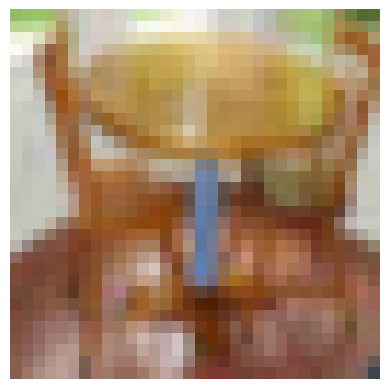

In [296]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv = False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    
    img = tensor_img.numpy()
    
    if yuv == False:
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        plt.imshow(img, cmap = 'jet')
        plt.axis('off')
        plt.show()

# Supponiamo che 'train_loader' sia già definito
# Carica un batch dal train_loader (ad esempio, il primo batch)
for batch in train_loader:
    image_tensor, filename = batch
    image_tensor = batch[0][0]  # La forma è (C, H, W)

    # Visualizza l'immagine
    print(f"Filename: {batch[1][0]}")
    imshow(image_tensor)

    break  # Visualizza solo la prima immagine del primo batch


Filename: cirrocumulus_s_001251.png


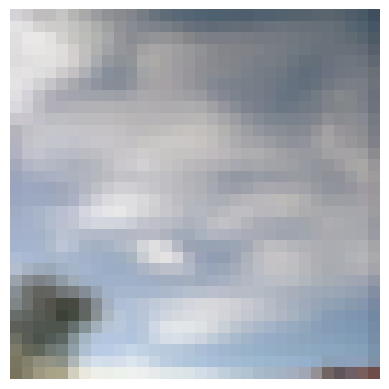

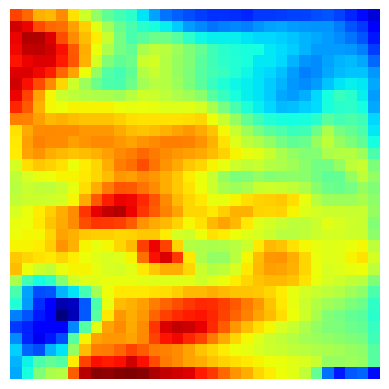

In [297]:
def rgb_to_yuv(image_tensor):
    """
    Converte un'immagine PyTorch tensor (C, H, W) da RGB a YUV usando OpenCV.
    """
    # Converti il tensor in NumPy e permuta gli assi (C, H, W) -> (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Converti da [0,1] (normalizzato da ToTensor) a [0,255]
    img_np = (img_np * 255).astype(np.uint8)

    # Converti da RGB a YUV
    img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)

    return torch.tensor(img_yuv).permute(2, 0, 1)  # Riporta a (C, H, W)

for batch in train_loader:
    image_tensor, filename = batch  # Estrai dati dal batch

    image_rgb = image_tensor[0]  # Prima immagine del batch (RGB)
    image_yuv = rgb_to_yuv(image_rgb)  # Conversione a YUV

    print(f"Filename: {filename[0]}")
    imshow(image_rgb)
    imshow(image_yuv[0], yuv = True)  # Mostra solo il canale Y (Luminosità)

    break  # Visualizza solo il primo batch



Filename: chimp_s_001619.png


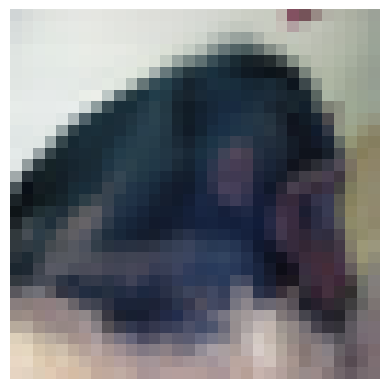

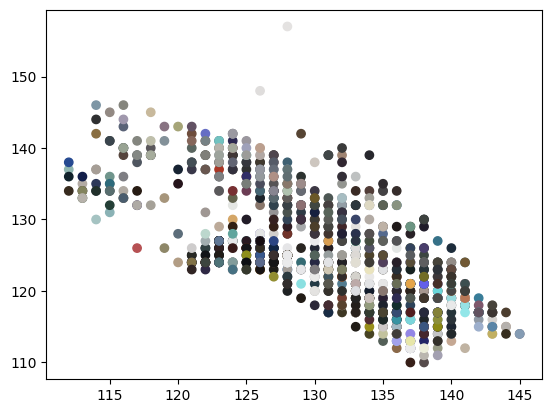

In [245]:
def plot_uv(train_loader, idx = 0):
    num = 0
    for batch in train_loader:
        if num == 1:
            break 
        image_tensor, filename = batch
        
        image_yuv = rgb_to_yuv(image_tensor[0])
 
        colors = image_tensor[0].reshape(-1, 3) 

        U_chan = image_yuv[1, :, :].flatten()
        V_chan = image_yuv[2, :, :].flatten()

        
        print(f"Filename: {filename[0]}")
        imshow(image_tensor[0])
        plt.scatter(U_chan, V_chan, c = colors)
        num += 1
plot_uv(train_loader)

# CNN construction

In this first section we are going to construct the structure encoder <-> decoder of the network. 
The network works as following:
since our task is image colorization, we want to predict the `UV` channels given a grayscale image.
1. Input (grayscale image): we want to pass the grayscale channel `Y` to the network;
2. Target (color image): the target should contain the full color image, i.e. the `YUV` image.

In [318]:
# Creating a new Dataset class in order to extract the images (both RGB and YUV)

class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames  # Names of the images
        self.images_data = images_data  # Images (in RGB or YUV format)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get image data (RGB image) from the dataset
        img_data = self.images_data[idx]
        
        
        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # Assuming RGB
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HWC format
        
        # Convert the image from RGB to YUV
        img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
        
        # Extract Y channel as input (grayscale)
        img_y = img_yuv[:, :, 0]  # Y channel (luminance)
        
        # Extract UV channels as target (chrominance)
        img_uv = img_yuv[:, :, 1:]  # U and V channels (chrominance)
        
        # Convert Y to 1 channel image (grayscale)
        #img_y = np.expand_dims(img_y, axis=-1)  # Add channel dimension (H, W) -> (H, W, 1)


        # Convert to Image format (needed for transforms)
        img_y = Image.fromarray(img_y.astype(np.uint8))
        img_uv = Image.fromarray(img_uv.astype(np.uint8))

        # Apply any transformations if provided
        if self.transform:
            img_y = self.transform(img_y)  # Grayscale input image
            img_uv = self.transform(img_uv)  # UV channels as output
            img_rgb = self.transform(img_rgb)


        return img_rgb, img_y, img_uv
    
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    #transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for grayscale input
])

train_set = unpickle('train')
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa
images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Create dataset
dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


# Example of loading data
for img_y, img_uv, filename in train_loader:
    print(img_y.shape, img_uv.shape, filename)
    break  # Just checking the first batch


# Provare a visualizzare il risultato, provare a inserire nella rete neurale 


torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 32, 32]) tensor([[[[0.4039, 0.4000, 0.3961,  ..., 0.4431, 0.4235, 0.3961],
          [0.4235, 0.4196, 0.4078,  ..., 0.4510, 0.4275, 0.3843],
          [0.4000, 0.4039, 0.3843,  ..., 0.4471, 0.4235, 0.3804],
          ...,
          [0.3294, 0.3569, 0.3922,  ..., 0.3451, 0.3412, 0.3569],
          [0.3255, 0.3647, 0.4000,  ..., 0.3451, 0.3451, 0.3686],
          [0.3294, 0.3725, 0.4000,  ..., 0.3373, 0.3529, 0.3765]],

         [[0.4941, 0.5176, 0.5216,  ..., 0.5255, 0.5176, 0.4863],
          [0.5333, 0.5451, 0.5216,  ..., 0.5412, 0.5255, 0.4902],
          [0.5020, 0.5216, 0.4863,  ..., 0.5373, 0.5176, 0.4941],
          ...,
          [0.4588, 0.5020, 0.5373,  ..., 0.4157, 0.4039, 0.4314],
          [0.4627, 0.5176, 0.5686,  ..., 0.4157, 0.4196, 0.4471],
          [0.4627, 0.5176, 0.5647,  ..., 0.4157, 0.4353, 0.4588]]],


        [[[0.4392, 0.4392, 0.4784,  ..., 0.4863, 0.4784, 0.4706],
          [0.4314, 0.4314, 0.4588,  ..., 0.4863, 0

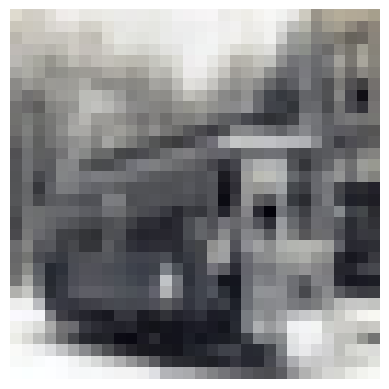

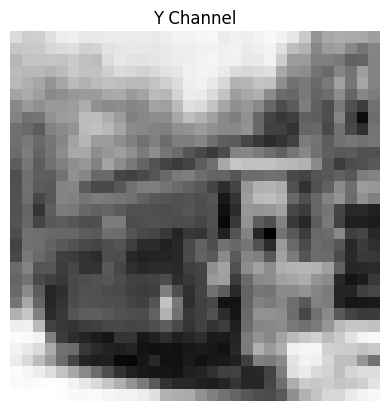

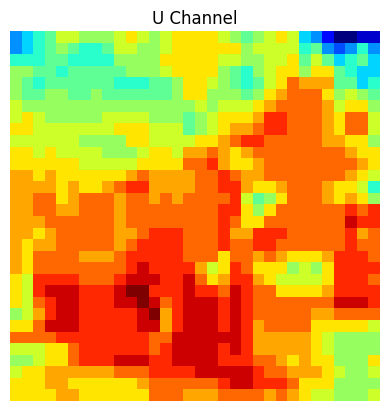

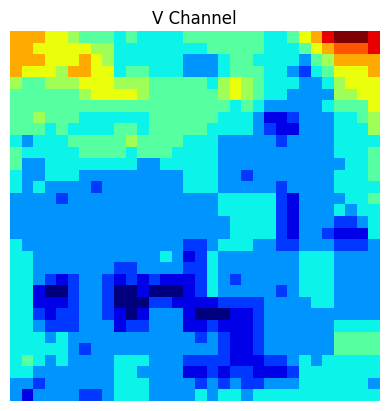

In [329]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv=False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    img = tensor_img.numpy()

    if not yuv:
        # Per immagini RGB
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        # Se yuv è True, separa i canali Y, U, V e visualizzali separatamente
        # Controlla se l'immagine ha 3 canali
        if img.shape[0] == 3:  # (Y, U, V) -> (C, H, W)
            y_channel = img[0]  # Canale Y
            u_channel = img[1]  # Canale U
            v_channel = img[2]  # Canale V

            # Visualizza il canale Y in scala di grigi
            plt.imshow(y_channel, cmap='gray')
            plt.title('Y Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale U con una mappa di colori
            plt.imshow(u_channel, cmap='jet')
            plt.title('U Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale V con una mappa di colori
            plt.imshow(v_channel, cmap='jet')
            plt.title('V Channel')
            plt.axis('off')
            plt.show()
        
        else:
            print("L'immagine YUV non ha 3 canali. Verifica la forma dell'immagine.")

# Esempio di utilizzo
# Supponiamo che tensor_img sia una variabile contenente l'immagine YUV
# tensor_img = ...

# Visualizza l'immagine YUV separando i canali
for batch in train_loader:
    image_tensor, _, _ = batch  # Estrai dati dal batch


    image_rgb = image_tensor[0, :, :, :]  # Prima immagine del batch (RGB)
    
    image_yuv = rgb_to_yuv(image_rgb)  # Conversione a YUV

    imshow(image_rgb)
    imshow(image_yuv, yuv = True)  # Mostra solo il canale Y (Luminosità)

    break  # Visualizza solo il primo batch

In [311]:
# Definisci il dataset YUV
class YUVImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converte in RGB
        image_yuv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YUV)  # Converte in YUV

        Y_channel = image_yuv[:, :, 0]  # Y (luminosità)
        U_channel = image_yuv[:, :, 1]  # U (Cb)
        V_channel = image_yuv[:, :, 2]  # V (Cr)

        Y_channel = np.expand_dims(Y_channel, axis=2)  # (H, W) -> (H, W, 1)
        U_channel = np.expand_dims(U_channel, axis=2)
        V_channel = np.expand_dims(V_channel, axis=2)

        # Combina Y, U, V in un unico array se vuoi usarli come target
        target = np.concatenate([U_channel, V_channel], axis=2)

        # Trasformazioni opzionali
        if self.transform:
            Y_channel = self.transform(Y_channel)

        return Y_channel, target

# Definire la rete neurale
class YUVNet(nn.Module):
    def __init__(self):
        super(YUVNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 32, 32) -> (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),  # Riduzione dimensione: (32, 32) -> (16, 16)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2)   # Riduzione dimensione: (16, 16) -> (8, 8)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 2 * 8 * 8)  # Predizione per U e V (due canali)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        x = x.view(x.size(0), 2, 8, 8)  # Riformattiamo l'output per ottenere (U, V)
        return x

# Creare un dataset (esempio con immagini in una lista di file)
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg"]  # Modifica con i tuoi file
dataset = YUVImageDataset(image_paths)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Creazione e addestramento del modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVNet().to(device)

# Funzione di perdita e ottimizzatore
criterion = nn.MSELoss()  # Loss per regressione continua
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Ciclo di addestramento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, target in train_loader:
        Y_channel = Y_channel.to(device).float()  # Converti in float
        target = target.to(device).float()  # Converti in float

        optimizer.zero_grad()
        
        # Forward pass
        output = model(Y_channel)

        # Calcolare la perdita
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Salva il modello addestrato
torch.save(model.state_dict(), "yuv_model.pth")



error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [9]:

first_batch = next(iter(train_loader))
print(len(first_batch))

32


NameError: name 'self' is not defined